Want to make better PS1 image scenes for TESSS

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

In [2]:
def Get_PS1(RA, DEC,Size, filt='i'):
    '''
    Size limit seems to be around 1000
    '''
    if Size > 30:
        raise ValueError('Thats too big man')
    Scale = 100
    size = Size * Scale#int((Size + 2*np.sqrt(1/2)*Size) * Scale ) # last term is a fudge factor 
    fitsurl = sd.geturl(RA,DEC, size=size, filters=filt, format="fits")
    if len(fitsurl) > 0:
        fh = sd.fits.open(fitsurl[0])
        return fh[0]
        ps = fh[0].data
        ps_wcs = sd.WCS(fh[0])
        return ps, ps_wcs
    else:
        raise ValueError("No PS1 images at for this coordinate") 
        return 

In [3]:
# SN2020amx
ra = 148.5706917	
dec = 51.68126944
size = 13
# SN2020fqv
ra = 189.1385827     
dec = 11.2316599
# host
ra = 189.1428830     
dec = 11.2386300
#ps, pswcs = Get_PS1(ra,dec,size)

In [4]:
pbs = ['r','i','z','y']
factor = [0.677,0.975,0.977,0.673]
# factors from colour fitting
factor = [0.41656058, 1.12264514, 0.95252585, 0.76186266] 
#factor = [0,1,0,0]

In [5]:
def Combined_image(RA,DEC,Size,pbs,Coeff):
    flux = 0
    for i in range(len(pbs)):
        f = Get_PS1(RA,DEC,Size, filt=pbs[i])
        #zp =f.header['FPA.ZP']
        #mag = -2.5*np.log10(f.data) + zp
        #flux = 10**(-1/2.5*(mag+48.6)) 
        ff = f.data
        ff[ff<0] = 0
        flux += ff * Coeff[i]
    T = flux#-2.5*np.log10(flux) - 48.6
    #T = 10**(-1/2.5*(m-20.44))
    ps_wcs = sd.WCS(f)
    return T, ps_wcs

def Simple_image(RA,DEC,Size):
    flux = 0
    f = Get_PS1(RA,DEC,Size, filt='g')
    zp =f.header['FPA.ZP']
    g = -2.5*np.log10(f.data) + zp
    f = Get_PS1(RA,DEC,Size, filt='i')
    zp =f.header['FPA.ZP']
    i = -2.5*np.log10(f.data) + zp
    T = i - 0.00206*(g - i)**3 - 0.02370*(g - i)**2 + 0.00573*(g - i) - 0.3078
    ps_wcs = sd.WCS(f)
    return T, ps_wcs


In [6]:
com,wcs = Combined_image(ra,dec,size,pbs,factor)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [280]:
com,wcs = Simple_image(ra,dec,size)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [7]:
tpf = sd.Get_TESS(ra,dec,12)

In [8]:
def Get_TESS_corners(TESS,PS1_wcs):
    x,y = TESS.flux.shape[1:]
    # include the top corners for the last pixels
    x += 1; y += 1

    corners = np.zeros((2,x,y))
    ps_corners = np.zeros((2,x,y))
    x_arr = np.arange(0,x)
    y_arr = np.arange(0,y)

    for i in range(x):
        for j in range(y):
            corners[:,i,j] = sd.pix2coord(x_arr[i],y_arr[j],TESS.wcs)
            ps_corners[:,i,j] = sd.coord2pix(corners[0,i,j],corners[1,i,j],PS1_wcs)
            
    return ps_corners

tess_corners = Get_TESS_corners(tpf, wcs)

In [9]:
com = 10**(-1/2.5*(T-20.44))

NameError: name 'T' is not defined

In [ ]:
plt.figure()
#plt.subplot(projection=wcs)
plt.imshow(com,origin='lower')#,vmax=50000,vmin=0)
plt.colorbar()
#z = np.arange(0,x*y,1)
plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c='r',s=2)

In [10]:
def Regrid_PS(PS1, Corners):
    dim1, dim2 = Corners.shape[1:]
    dim1 -= 1; dim2 -= 1
    global px, py
    px, py = np.where(PS1)
    global squares
    squares = np.array(sd.Make_squares(Corners))
    print(squares)
    square_num = np.arange(0,len(squares))

    points = np.zeros((len(px),2))
    points[:,0] = px
    points[:,1] = py

    global pspixels
    pspixels = sd.Footprint_square(Corners, points)

    global psimage
    psimage = PS1.copy()

    pool = sd.MultiPool()
    values = list(pool.map(sd.Pix_sum, square_num))
    pool.close()

    PS_scene = np.array(values)
    PS_scene = np.nansum(PS_scene,axis=0)
    PS_scene = PS_scene.astype('float')
    PS_scene = PS_scene.reshape(dim1,dim2)
    return PS_scene.T

In [11]:
ps1_scene = sd.Regrid_PS(com,tess_corners)
print(np.nanmin(ps1_scene))
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)
ps1_scene_c = sd.signal.fftconvolve(ps1_scene, PRF, mode='same')

82536.421875


In [62]:
np.nanmin(ps1_scene_c)

23484.72074825177

In [12]:
from astropy.visualization import (SqrtStretch, ImageNormalize)

In [78]:
f = com /1000
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.title('PS1 image')
ff= f.copy()
ff[np.isnan(ff)] = 0
norm = ImageNormalize(vmin=0, 
                      vmax=800, stretch=SqrtStretch())
plt.imshow(np.fliplr(ff),origin='',norm=norm)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.subplot(222)
plt.title('PS1 downsampled')
plt.imshow(ps1_scene.T,origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(223)
plt.title('PS1 downsampled &\n convolved with TESS PSF')
plt.imshow(ps1_scene_c.T,origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.subplot(224)
plt.title('TESS image')
plt.imshow(tpf.flux[100],origin='')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

plt.tight_layout()
#plt.savefig('ngc4568_syndiff.pdf')

<IPython.core.display.Javascript object>

RuntimeError: latex was not able to process the following string:
b'PS1 downsampled &'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/ryanr/.matplotlib/tex.cache/55f94ecd4415f1d21568c4de6fa4ec4c.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/omsenc.dfu)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 55f94ecd4415f1d21568c4de6fa4ec4c.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.14 ...00}{15.000000}{\rmfamily PS1 downsampled &
                                                  }
No pages of output.
Transcript written on 55f94ecd4415f1d21568c4de6fa4ec4c.log.




In [18]:
from scipy.ndimage import rotate

In [19]:
from matplotlib import rc
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [29]:
f = com /1000
ps = np.fliplr(f)
kernal = sd.Interp_PRF(tpf.row+5,tpf.column + 5,tpf.camera,tpf.ccd,100)
test = sd.signal.fftconvolve(rotate(np.fliplr(f),-20), kernal,mode='same')
tess_image = tpf.flux[300] - np.nanmin(tpf.flux[300])
down = ps1_scene_c.T / np.nanmax(ps1_scene_c) * np.nanmax(tess_image)#
#down = sd.Downsample(test,21/.258,pix_response=False)  #Regrid_PS(f,tess_corners)
#from skimage.measure import block_reduce
#block = block_reduce(test,block_size=(81,81),func=np.nansum)
#down = block

In [32]:
21/.258

81.3953488372093

In [33]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<IPython.core.display.Javascript object>


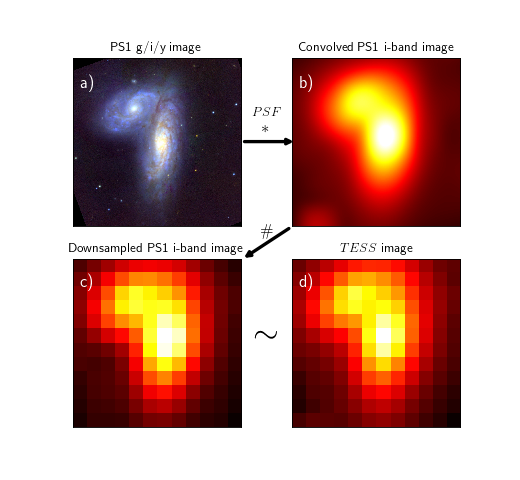

In [31]:


fig = plt.figure(figsize=(6.5,6))
plt.subplot(2,2,1)
plt.title(r'PS1 g/i/y image')
norm = ImageNormalize(vmin=np.nanmin(ps)+0.01*np.nanmin(ps), 
                      vmax=np.nanmax(ps)-0.98*np.nanmax(ps))
#plt.imshow(rotate(ps,-20),origin='lower',norm=norm,cmap='hot')
plt.imshow(image,origin='lower')
plt.xlim(250,1350)
plt.ylim(300,1400)
plt.text(300,1200,'a)',fontsize=15,color='w',weight='bold')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

# annotations
plt.annotate('', xy=(1.33, .5), xycoords='axes fraction', xytext=(1.01, .5), 
             arrowprops=dict(arrowstyle="->", color='k',lw=3))

plt.annotate(r'$*$', xy=(1.1, .55), xycoords='axes fraction', xytext=(1.13, .55),fontsize=15)
plt.annotate(r'$PSF$', xy=(1.1, .55), xycoords='axes fraction', xytext=(1.07, .65),fontsize=12)


            
plt.subplot(2,2,2)
plt.title('Convolved PS1 i-band image')
norm = ImageNormalize(vmin=np.nanmin(test)+0.1*np.nanmin(test), 
                      vmax=np.nanmax(test)-0.1*np.nanmax(test), stretch=SqrtStretch())
#eh =rotate(np.fliplr(test),-20)
#eh[eh==0] = np.nanmin(test)
plt.imshow(test,origin='lower',norm=norm,cmap='hot')
plt.xlim(250,1350)
plt.ylim(300,1400)
plt.text(300,1200,'b)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

# annotations
plt.annotate('', xy=(-0.3, -0.2), xycoords='axes fraction', xytext=(-0.01, -0.01), 
             arrowprops=dict(arrowstyle="->", color='k',lw=3))
plt.annotate(r'\#', xy=(-0.2, -0.2), xycoords='axes fraction', xytext=(-0.19, -0.06),fontsize=15)

plt.subplot(2,2,3)
plt.title('Downsampled PS1 i-band image')
norm = ImageNormalize(vmin=np.nanmin(down)+0.1*np.nanmin(down), 
                      vmax=np.nanmax(down)-0.1*np.nanmax(down), stretch=SqrtStretch())
plt.imshow(down,origin='lower',norm=norm,cmap='hot')
#plt.xlim(3-.5,16-.5)
#plt.ylim(4-.5,17-.5)
plt.text(0,9.5,'c)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.annotate(r'$\sim$', xy=(1.05, .5), xycoords='axes fraction', xytext=(1.08, .5),fontsize=30)

plt.subplot(2,2,4)
plt.title('$TESS$ image')
norm = ImageNormalize(vmin=np.nanmin(tess_image)+0.1*np.nanmin(tess_image), 
                      vmax=np.nanmax(tess_image)-0.1*np.nanmax(tess_image), stretch=SqrtStretch())
plt.imshow(tess_image,origin='lower',norm=norm,cmap='hot')
plt.text(0,9.5,'d)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('PS_TESS_NGC4568.pdf')



<IPython.core.display.Javascript object>


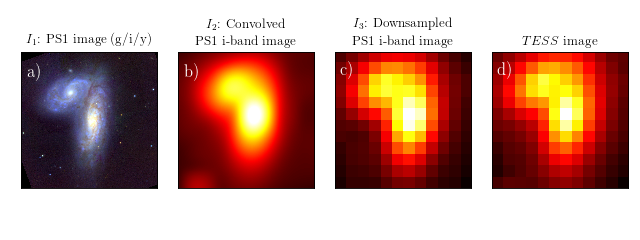

In [47]:
fig = plt.figure(figsize=(8,3))
plt.subplot(1,4,1)
plt.title(r'$I_1$: PS1 image (g/i/y)')
norm = ImageNormalize(vmin=np.nanmin(ps)+0.01*np.nanmin(ps), 
                      vmax=np.nanmax(ps)-0.98*np.nanmax(ps))
#plt.imshow(rotate(ps,-20),origin='lower',norm=norm,cmap='hot')
plt.imshow(image,origin='lower')
plt.xlim(250,1350)
plt.ylim(300,1400)
plt.text(300,1200,'a)',fontsize=15,color='w',weight='bold')
#plt.text(300,1000,r'$I_1$',fontsize=15,color='w',weight='bold')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

# annotations
#plt.annotate('', xy=(1.5, .5), xycoords='axes fraction', xytext=(1.01, .5), 
#             arrowprops=dict(arrowstyle="->", color='k',lw=3))

#plt.annotate(r'$*$', xy=(1.1, .55), xycoords='axes fraction', xytext=(1.13, .55),fontsize=15)
#plt.annotate(r'$*PSF$', xy=(1.1, .55), xycoords='axes fraction', xytext=(1.07, .65),fontsize=12)


            
plt.subplot(1,4,2)
plt.title('$I_2$: Convolved \nPS1 i-band image')
norm = ImageNormalize(vmin=np.nanmin(test)+0.1*np.nanmin(test), 
                      vmax=np.nanmax(test)-0.1*np.nanmax(test), stretch=SqrtStretch())
#eh =rotate(np.fliplr(test),-20)
#eh[eh==0] = np.nanmin(test)
plt.imshow(test,origin='lower',norm=norm,cmap='hot')
plt.xlim(250,1350)
plt.ylim(300,1400)
plt.text(300,1200,'b)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

# annotations
#plt.annotate('', xy=(-0.3, -0.2), xycoords='axes fraction', xytext=(-0.01, -0.01), 
#             arrowprops=dict(arrowstyle="->", color='k',lw=3))
#plt.annotate(r'\#', xy=(-0.2, -0.2), xycoords='axes fraction', xytext=(-0.19, -0.06),fontsize=15)

plt.subplot(1,4,3)
plt.title('$I_3$: Downsampled \n PS1 i-band image')
norm = ImageNormalize(vmin=np.nanmin(down)+0.1*np.nanmin(down), 
                      vmax=np.nanmax(down)-0.1*np.nanmax(down), stretch=SqrtStretch())
plt.imshow(down,origin='lower',norm=norm,cmap='hot')
#plt.xlim(3-.5,16-.5)
#plt.ylim(4-.5,17-.5)
plt.text(0,9.5,'c)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)

#plt.annotate(r'$\sim$', xy=(1.05, .5), xycoords='axes fraction', xytext=(1.08, .5),fontsize=30)

plt.subplot(1,4,4)
plt.title('$TESS$ image')
norm = ImageNormalize(vmin=np.nanmin(tess_image)+0.1*np.nanmin(tess_image), 
                      vmax=np.nanmax(tess_image)-0.1*np.nanmax(tess_image), stretch=SqrtStretch())
plt.imshow(tess_image,origin='lower',norm=norm,cmap='hot')
plt.text(0,9.5,'d)',fontsize=15,color='w')
plt.gca().set_xticklabels(['']*10)
plt.gca().set_yticklabels(['']*10)
plt.gca().tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.savefig('PS_TESS_NGC4568_linear_colour.pdf')

In [15]:
import matplotlib.image as mpimg

<IPython.core.display.Javascript object>


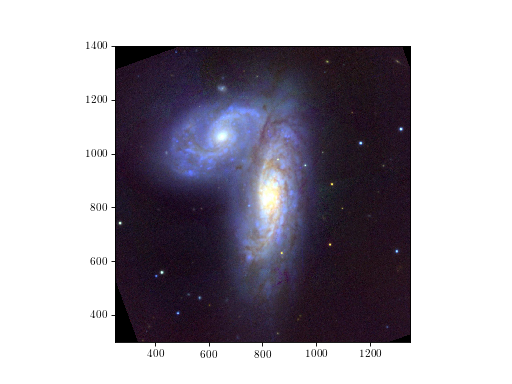

(300, 1400)

In [27]:
image = mpimg.imread("/Users/ryanr/Desktop/fitscut.jpeg")
image = np.flipud(image)
image = np.fliplr(image)
image = rotate(image,-20)
plt.figure()
plt.imshow(image,origin='lower')
plt.xlim(250,1350)
plt.ylim(300,1400)

In [14]:
col

['https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=189.142883&dec=11.23863&size=1300&format=jpg&filetypes=stack&red=/rings.v3.skycell/1548/087/rings.v3.skycell.1548.087.stk.y.unconv.fits',
 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=189.142883&dec=11.23863&size=1300&format=jpg&filetypes=stack&red=/rings.v3.skycell/1548/087/rings.v3.skycell.1548.087.stk.z.unconv.fits',
 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=189.142883&dec=11.23863&size=1300&format=jpg&filetypes=stack&red=/rings.v3.skycell/1548/087/rings.v3.skycell.1548.087.stk.i.unconv.fits',
 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=189.142883&dec=11.23863&size=1300&format=jpg&filetypes=stack&red=/rings.v3.skycell/1548/087/rings.v3.skycell.1548.087.stk.r.unconv.fits',
 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=189.142883&dec=11.23863&size=1300&format=jpg&filetypes=stack&red=/rings.v3.skycell/1548/087/rings.v3.skycell.1548.087.stk.g.unconv.fits']

<IPython.core.display.Javascript object>


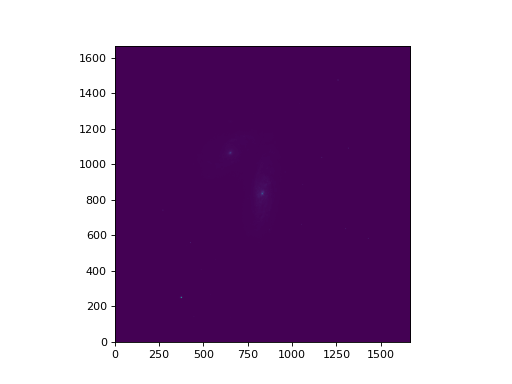

<IPython.core.display.Javascript object>


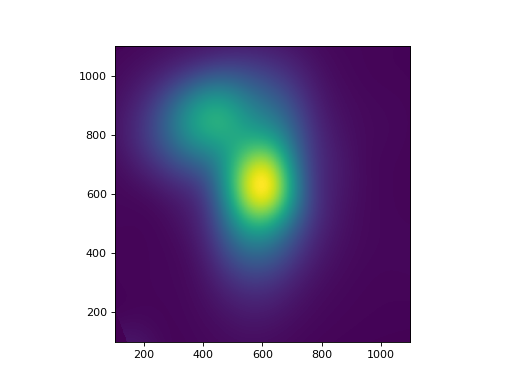

(100, 1100)

In [81]:
plt.figure()
plt.imshow(rotate(np.fliplr(f),-20),origin='lower')

plt.figure()
plt.imshow(eh.data,origin='lower')
plt.xlim(100,1100)
plt.ylim(100,1100)

<IPython.core.display.Javascript object>


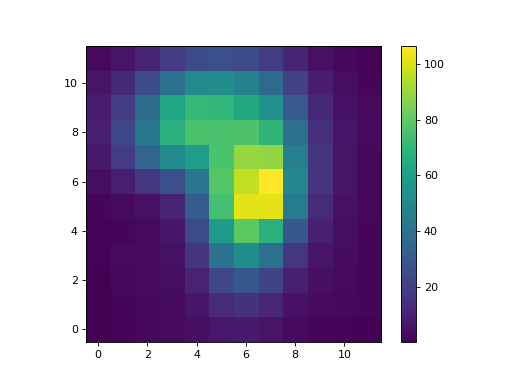

In [285]:
nps1 = ps1_scene_c.T #/ np.nanmax(ps1_scene_c)
ntess = tpf.flux[100]  #/ np.nanmax(tpf.flux[100]) -.32
plt.figure()
plt.imshow(nps1/ntess,origin='')
plt.colorbar()

In [71]:
t = np.nanmedian(tpf.flux,axis=0) #- np.nanmin(tpf.flux,axis=(1,2))[:,np.newaxis,np.newaxis]
t = t - np.nanmin(t)

In [72]:
t

array([[   8.91716  ,   16.423218 ,   15.561813 ,   14.8003235,
          24.85405  ,   39.029327 ,   46.675995 ,   33.96399  ,
          17.819733 ,    7.6691284,    2.6182709,    0.       ],
       [   1.6383362,    6.8330994,   12.950485 ,   21.326492 ,
          41.797577 ,   74.55411  ,   88.03664  ,   61.6476   ,
          30.733704 ,   13.744049 ,    4.9756317,    1.4266052],
       [   3.2856293,   13.245056 ,   14.664825 ,   26.159988 ,
          67.06496  ,  136.97246  ,  165.89702  ,  115.26213  ,
          54.823944 ,   23.758041 ,    8.969559 ,    2.7800598],
       [   6.362152 ,   15.223648 ,   19.697113 ,   37.45511  ,
         107.58818  ,  247.7152   ,  307.31567  ,  210.39003  ,
          97.32808  ,   40.275604 ,   15.6306   ,    6.8393707],
       [  14.415253 ,   20.17987  ,   29.462616 ,   55.459366 ,
         155.5345   ,  402.92126  ,  602.1901   ,  371.52966  ,
         159.59749  ,   64.63248  ,   23.04245  ,    9.650497 ],
       [  23.175858 ,   31.709473 ,

<IPython.core.display.Javascript object>


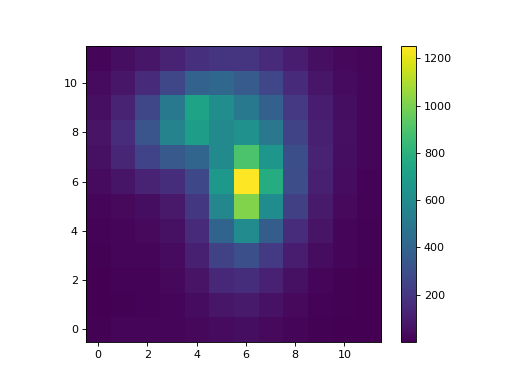

In [74]:
plt.figure()
plt.imshow(t+.01,origin='')
plt.colorbar()

In [102]:
sub = nps1 - npnps1[0,-1]

In [103]:
np.nanmin(sub)

-16476.339192038417

In [105]:
scale = (sub / t).flatten()

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [106]:
scale.flatten

<function ndarray.flatten>

<IPython.core.display.Javascript object>


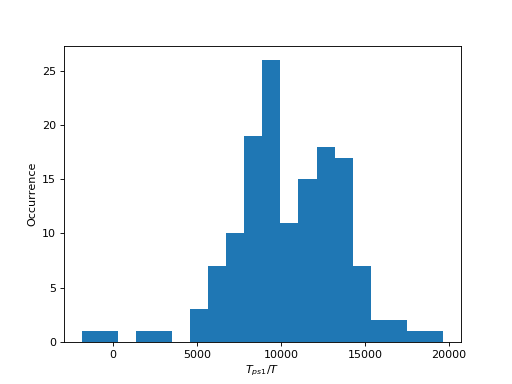

In [279]:
plt.figure()
plt.hist(scale,bins=20);
plt.ylabel('Occurrence')
plt.xlabel('$T_{ps1} / T$')
plt.savefig('scale_distribution.pdf')

<IPython.core.display.Javascript object>


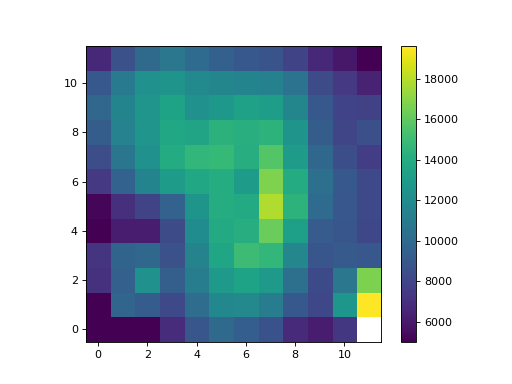

In [294]:
plt.figure()
plt.imshow((sub / (t)),origin='',vmin=5000)
plt.colorbar()

In [118]:
np.where(np.nanmax(t) == t)

(array([6]), array([6]))

In [268]:
10**(-2/5 *(23-25))

6.309573444801933

## Look at how the colours map over the image region

In [157]:
g = Get_PS1(ra,dec,size,filt='g').data
g[g<0] = np.nan
g = -2.5*np.log10(g) + 25
g[g>21] = np.nan
r = Get_PS1(ra,dec,size,filt='r').data
r[r<0] = np.nan
r = -2.5*np.log10(r) + 25
r[r>21] = np.nan
i = Get_PS1(ra,dec,size,filt='i').data
i[i<0] = np.nan
i = -2.5*np.log10(i) + 25
i[i>21] = np.nan

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


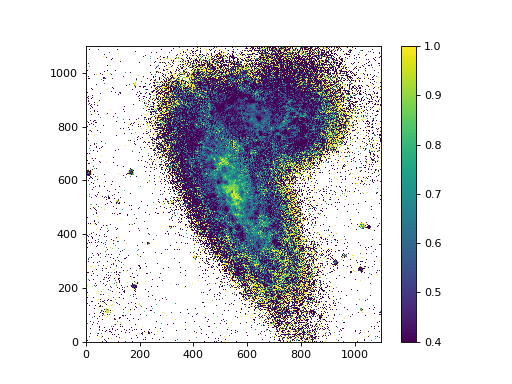

In [158]:
plt.figure()
thing = g-r 
#thing[np.isnan(thing)] = 0
plt.imshow(thing,origin='',vmin=0.4,vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


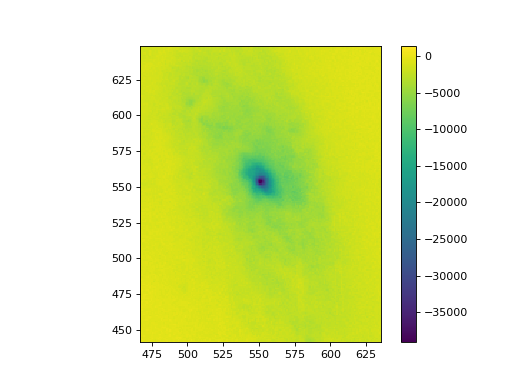

In [151]:
plt.figure()
thing = g-r 
#thing[np.isnan(thing)] = 0
plt.imshow(thing,origin='')
plt.colorbar()

In [293]:
ps1_g= sd.Regrid_PS(g,tess_corners)
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)
ps1_g_c = sd.signal.fftconvolve(ps1_g, PRF, mode='same').T

ps1_r= sd.Regrid_PS(r,tess_corners)
r_c = sd.signal.fftconvolve(ps1_r, PRF, mode='same').T

<IPython.core.display.Javascript object>


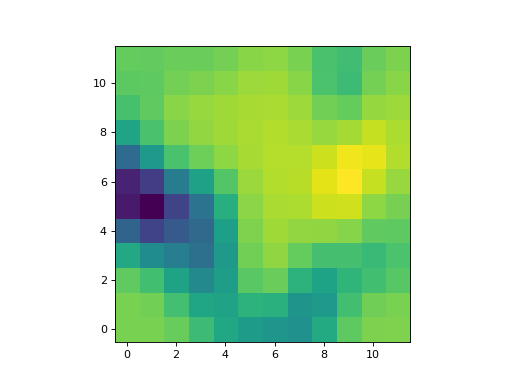

In [165]:
plt.figure()
plt.imshow(ps1_g_c-ps1_r_c,origin='')

In [291]:
colours = (-2.5*np.log10(ps1_g_c)+2.5*np.log10(ps1_r_c) ).flatten()

<IPython.core.display.Javascript object>


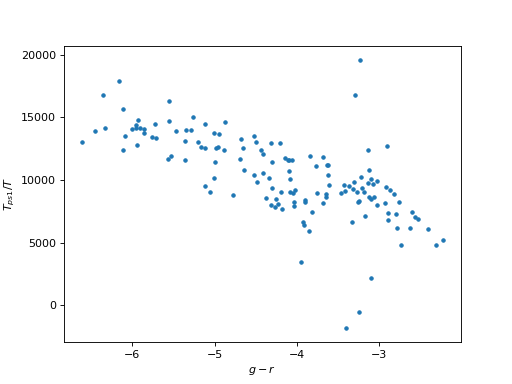

In [292]:
plt.figure()
plt.plot(colours,scale,'.')
plt.xlabel('$g - r$')
plt.ylabel('$T_{ps1} / T$')
plt.savefig('scalefactor_colour.pdf')

In [420]:
size

11

In [421]:
g = Get_PS1(ra,dec,13,filt='g').data
g[g<100] = np.nan
r = Get_PS1(ra,dec,13,filt='r').data
r[r<100] = np.nan
i = Get_PS1(ra,dec,13,filt='i').data
i[i<100] = np.nan
z = Get_PS1(ra,dec,13,filt='z').data
z[z<100] = np.nan
y = Get_PS1(ra,dec,13,filt='y').data
y[y<100] = np.nan

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [332]:
eh =Get_PS1(ra,dec,size,filt='r')

In [336]:
ps1wcs = sd.WCS(eh.header)

<IPython.core.display.Javascript object>


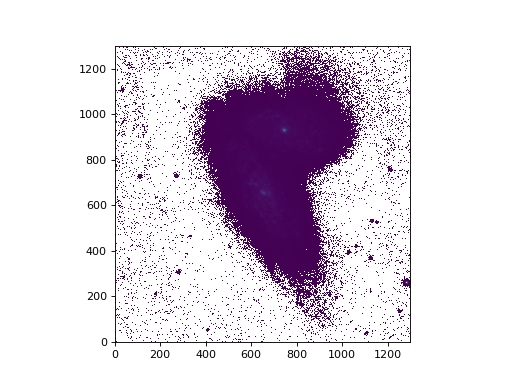

In [422]:
plt.figure()
plt.imshow(g,origin='')

In [435]:
PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
              tpf.camera,tpf.ccd)

tg = sd.Regrid_PS(g,tess_corners)
tg = sd.signal.fftconvolve(tg, PRF, mode='same').T
tr = sd.Regrid_PS(r,tess_corners)
tr = sd.signal.fftconvolve(tr, PRF, mode='same').T
ti= sd.Regrid_PS(i,tess_corners)
ti = sd.signal.fftconvolve(ti, PRF, mode='same').T
tz= sd.Regrid_PS(z,tess_corners)
tz = sd.signal.fftconvolve(tz, PRF, mode='same').T
ty= sd.Regrid_PS(y,tess_corners)
ty = sd.signal.fftconvolve(ty, PRF, mode='same').T

/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


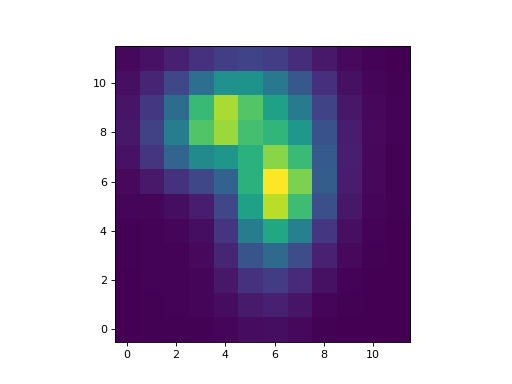

In [436]:
plt.figure()
plt.imshow(tg,origin='')

In [437]:
tess_corners.shape

(2, 13, 13)

In [374]:
def Fit_flux(coeffs,ps1,tess):
    combined = np.nansum(coeffs[:,np.newaxis,np.newaxis]*ps1,axis=0)
    combined -= np.nanmin(combined)
    tess[tess<=0] = np.nan
    scale = combined / tess
    
    chi2 = np.nansum((scale - np.nanmedian(scale))**2 / np.nanmedian(scale))
    residual = np.nansum(abs(scale - np.nanmedian(scale)))
    print(np.nansum(abs(combined - tess)))
    return np.nansum(abs(combined - tess))

def Fit_flux_pos(coeffs,ps1,tess,corners,prf):
    thing = coeffs[:-2]
    pos = coeffs[-2:]
    
    corners = corners + pos[:,np.newaxis,np.newaxis]
    summed = np.zeros_like(tess)
    for i in range(len(ps1)):
        tt = sd.Regrid_PS(ps1[i],corners)
        tt = sd.signal.fftconvolve(tt, prf, mode='same').T
        summed += tt * thing[i]
        
    return np.nansum(abs(summed - tess))

In [233]:
from scipy.optimize import minimize

In [441]:
coeffs = np.array([.1,.1,.1,.1])
bounds = ((0,1),(0,1),(0,1),(0,1))
ps1 = np.array([tr,ti,tz,ty])

In [254]:
coeffs = np.array([.1,.1,.1,.1,.1])
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1))
ps1 = np.array([tg,tr,ti,tz,ty])


In [442]:
res = minimize(Fit_flux, coeffs, args=(ps1,t),bounds=bounds)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


40918042.779694416
40918043.5796688
40918043.9270152
40918043.61894442
40918044.08753324
25797.23960876465
25796.43963438199
25796.092287980126
25796.398574754625
25795.93166522954
20450843.46275752
20450844.262731902
20450844.610078305
20450844.30200753
20450844.770596348
2839797.826680271
2839798.626654654
2839798.9740010556
2839798.665930278
2839799.1345190983
25797.23960876465
25796.43963438199
25796.092287980126
25796.398574754625
25795.93166522954
20450840.401492283
20450841.201466665
20450841.548813067
20450841.24074229
20450841.70933111
2839797.882670161
2839798.682644544
2839799.029990946
2839798.7219201685
2839799.1905089887
380367.95642617025
380368.7564005529
380369.1037469548
380368.7956761776
380369.2642649976
37536.1294516051
37536.92512172243
37537.270783174965
37536.96521091138
37537.432174616646
3116.6310326793596
3116.1430767322427
3115.9508307452916
3116.1490049414406
3115.8971270191787
30344.19555005199
30344.987834436804
30345.32995896031
30345.02766083773
30345.4

2297.505450997319
2297.4761760862802
2297.4989831539315
2297.492077530336
2297.493528133733
2297.505450997319
2297.4761760862802
2297.4989831539306
2297.4920775303353
2297.4935281337325
2297.505450997319
2297.4761760862802
2297.4989831539306
2297.4920775303353
2297.493528133733
2297.505450997319
25797.23960876465
25796.43963438199
25796.092287980126
25796.398574754625
25795.93166522954
2297.9798853197344
2297.982615907599
2297.9701817090904
2297.98026338095
2297.9819632446925
2297.6071318970307
2297.6098624848946
2297.5974282863867
2297.6075099582454
2297.6092098219883
2297.510222363836
2297.5129529517
2297.500518753192
2297.5106004250506
2297.512300288793
2297.485027537841
2297.487758125705
2297.475323927196
2297.4854055990554
2297.4871054627984
2297.4784773127394
2297.4853270112776
2297.4784213876824
2297.4798719910796
2297.491794854666
2297.4766923897314
2297.49591926009
2297.4890136364947
2297.4904642398924
2297.502387103478
2297.4762679835703
2297.498437808865
2297.4915321852704
2

In [443]:
res.x

array([0.00012229, 0.00013258, 0.        , 0.        ])

In [370]:
res.x

array([0.11310358, 0.10109161, 0.04903953, 0.        ])

In [362]:
tr/1000

array([[   4.59786664,   13.65611186,   19.52268144,   24.52854505,
          59.93561342,  116.09511342,  133.79192303,   86.23170108,
          31.19708027,   12.77922811,    7.7452808 ,    5.89172388],
       [   7.61674527,   20.68413154,   32.85455059,   49.41131827,
         122.43851142,  243.92211916,  286.44669275,  189.64754301,
          70.6889343 ,   24.92901073,   13.02057787,    8.89966925],
       [  13.3281942 ,   34.24265719,   48.96982851,   74.73146422,
         213.41628559,  453.90575228,  549.39819413,  376.13093597,
         145.9610003 ,   44.87616612,   19.28923532,   11.61449857],
       [  19.49868336,   41.47196282,   55.31511016,   99.23116975,
         335.55078864,  808.27942386, 1054.6787852 ,  722.02800075,
         275.21594834,   78.42633652,   28.63135415,   14.70492872],
       [  29.40544796,   43.71630164,   61.41386023,  142.41120095,
         489.74799063, 1289.36037586, 1859.49331887, 1330.74215739,
         475.23365167,  126.488565  ,   40.5

In [444]:
combined = np.nansum(res.x[:,np.newaxis,np.newaxis]*ps1,axis=0)
combined -= np.nanmin(combined)

<IPython.core.display.Javascript object>


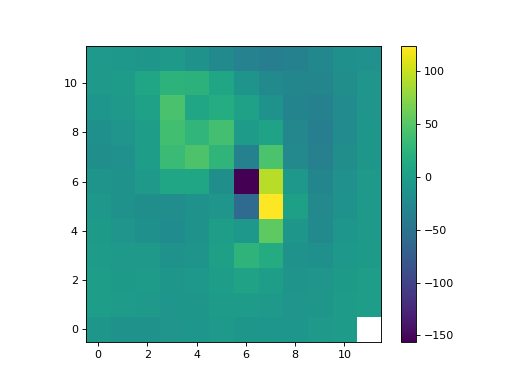

In [446]:
plt.figure()
plt.imshow((combined-t),origin='')
plt.colorbar()

<IPython.core.display.Javascript object>


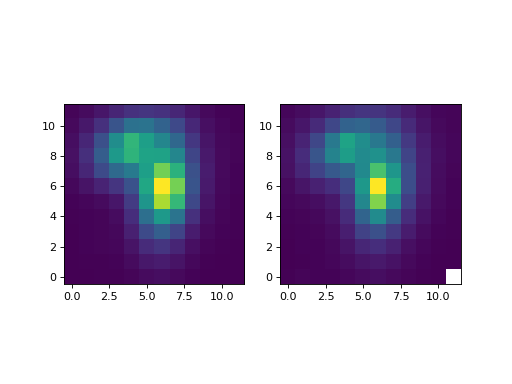

<IPython.core.display.Javascript object>


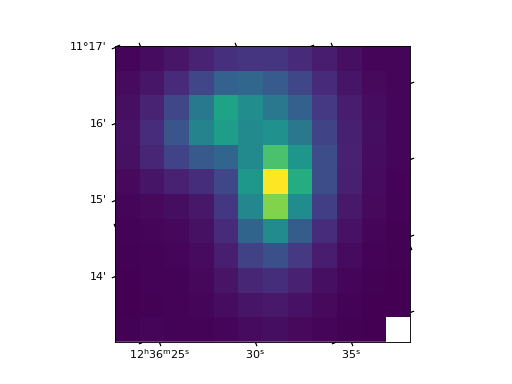

In [327]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(combined,origin='')
plt.subplot(1,2,2)
plt.imshow(t,origin='')

plt.figure()
plt.imshow(combined-t,origin='')

<IPython.core.display.Javascript object>


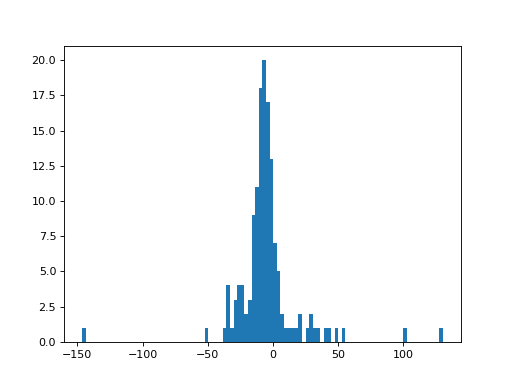

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  4.,  1.,  3.,  4.,  4.,  2.,  3.,  9., 11., 18., 20., 17.,
        13.,  7.,  5.,  2.,  1.,  1.,  1.,  1.,  2.,  0.,  1.,  2.,  1.,
         1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-146.37161333, -143.60634316, -140.84107299, -138.07580282,
        -135.31053266, -132.54526249, -129.77999232, -127.01472215,
        -124.24945198, -121.48418182, -118.71891165, -115.95364148,
        -113.18837131, -110.42310114, -107.65783098, -104.89256081,
        -102.12729064,  -99.36202047,  -96.5967503 ,  -93.83148014,
         -91.06620997,  -88.3009398 ,  -85.53566963,  -82.77039946,
         -80.0051293 ,  -7

In [314]:
plt.figure()
plt.hist((combined-t).flatten(),bins=100)

<IPython.core.display.Javascript object>


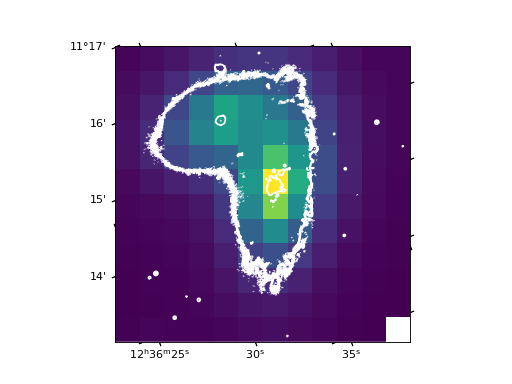

(-0.5, 11.5)

In [359]:
plt.figure()
ax = plt.subplot(projection=tpf.wcs)
ax.imshow(t)
ax.contour(np.log10(r),transform=ax.get_transform(ps1wcs), colors='w',levels=[1,1.1,2,3,4,5,6])
plt.ylim(-0.5,11.5)
plt.xlim(-0.5,11.5)

<IPython.core.display.Javascript object>


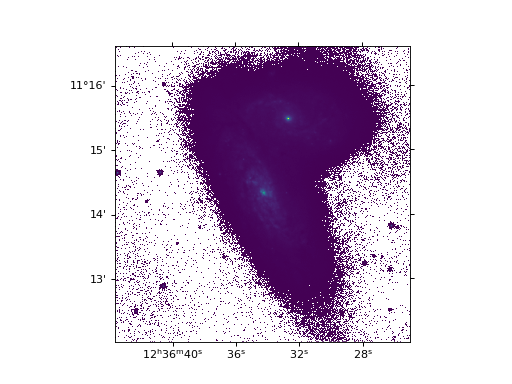

In [346]:
plt.figure()
ax = plt.subplot(projection=ps1wcs)
ax.imshow(r)

In [ ]:
Fit_flux_pos()

In [410]:
def Fit_flux_pos(pos,ps1,coeff,tess,corners,prf):
    
    corners = corners + pos[:,np.newaxis,np.newaxis]
    summed = np.zeros_like(tess)
    for i in range(len(ps1)):
        tt = sd.Regrid_PS(ps1[i],corners)
        tt = sd.signal.fftconvolve(tt, prf, mode='same').T
        summed += tt * coeff[i]
    print(pos)
    print(np.nansum(abs(summed - tess)))
    plt.figure()
    plt.imshow(summed - tess)
    plt.colorbar()
    return np.nansum(abs(summed - tess)/np.abs(tess))

In [401]:
co = res.x

[ 1. -1.]
2172.6665


<IPython.core.display.Javascript object>


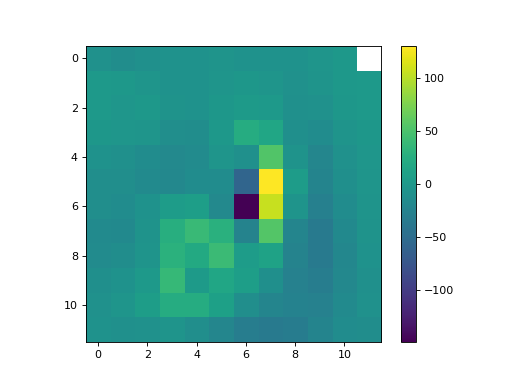

[ 1.00000001 -1.        ]
2172.6665


<IPython.core.display.Javascript object>


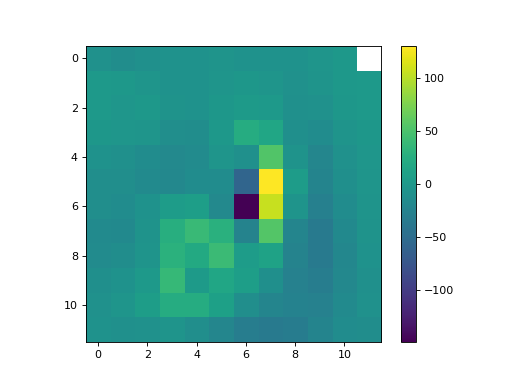

[ 1.         -0.99999999]
2172.6665


/Users/ryanr/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


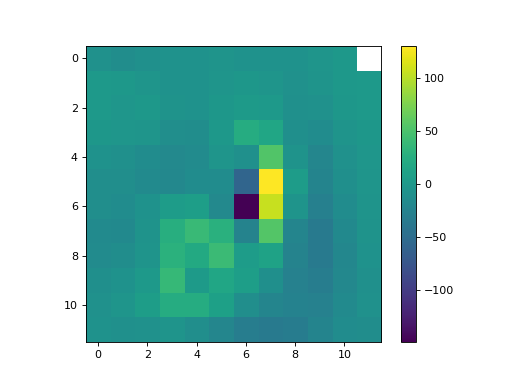

In [411]:
#coeffs = np.array([.1,.1,.1,.1,0,0])
#bounds = ((0,1),(0,1),(0,1),(0,1),(-100,100),(-100,100))
coeffs = np.array([1,-1])
bounds = ((-100,100),(-100,100))
ps1 = np.array([r,i,z,y])
eh = minimize(Fit_flux_pos, coeffs, args=(ps1,co,t,tess_corners,PRF),bounds=bounds)

In [406]:
eh

      fun: 2146.755
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([0., 0.])

In [412]:
tess_corners

array([[[ 1.28907018e+03,  1.25934559e+03,  1.22962092e+03,
          1.19989616e+03,  1.17017132e+03,  1.14044639e+03,
          1.11072138e+03,  1.08099628e+03,  1.05127110e+03,
          1.02154583e+03,  9.91820478e+02,  9.62095039e+02,
          9.32369516e+02],
        [ 1.21364196e+03,  1.18391734e+03,  1.15419263e+03,
          1.12446783e+03,  1.09474295e+03,  1.06501798e+03,
          1.03529293e+03,  1.00556779e+03,  9.75842569e+02,
          9.46117262e+02,  9.16391871e+02,  8.86666394e+02,
          8.56940832e+02],
        [ 1.13821410e+03,  1.10848943e+03,  1.07876468e+03,
          1.04903984e+03,  1.01931492e+03,  9.89589917e+02,
          9.59864827e+02,  9.30139651e+02,  9.00414390e+02,
          8.70689045e+02,  8.40963614e+02,  8.11238099e+02,
          7.81512498e+02],
        [ 1.06278658e+03,  1.03306187e+03,  1.00333708e+03,
          9.73612209e+02,  9.43887250e+02,  9.14162205e+02,
          8.84437076e+02,  8.54711862e+02,  8.24986562e+02,
          7.9526117

In [386]:
corners = tess_corners + pos[:,np.newaxis,np.newaxis]

In [389]:
summed = np.zeros_like(t)

In [390]:
summed

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [395]:
corners = corners + pos[:,np.newaxis,np.newaxis]
summed = np.zeros_like(t)
#for i in 1:#range(len(ps1)):
tt = sd.Regrid_PS(ps1[1],corners)
tt = sd.signal.fftconvolve(tt, PRF, mode='same').T
summed += tt * thing[1]

In [396]:
summed

array([[4.95565735e+02, 1.27566064e+03, 2.27527319e+03, 3.56845312e+03,
        7.71095801e+03, 1.55309365e+04, 1.95414785e+04, 1.40708857e+04,
        5.60197168e+03, 2.33882544e+03, 1.37408911e+03, 1.01360510e+03],
       [8.71346802e+02, 2.28320679e+03, 3.75408472e+03, 6.36525098e+03,
        1.53486953e+04, 3.29656836e+04, 4.23638906e+04, 3.02124180e+04,
        1.20793770e+04, 4.59100781e+03, 2.48021362e+03, 1.65671948e+03],
       [1.48209485e+03, 4.72076074e+03, 6.39379688e+03, 8.24826562e+03,
        2.55013848e+04, 6.18580938e+04, 8.26814922e+04, 5.92111211e+04,
        2.40867266e+04, 8.30626562e+03, 3.99879004e+03, 2.38320435e+03],
       [2.12249487e+03, 5.38381250e+03, 7.00339941e+03, 1.01962900e+04,
        3.90599453e+04, 1.09969438e+05, 1.60005828e+05, 1.16547352e+05,
        4.65715117e+04, 1.48857402e+04, 6.12394141e+03, 3.20507275e+03],
       [2.82935913e+03, 4.33136719e+03, 5.97729736e+03, 1.40053291e+04,
        5.65916836e+04, 1.73472062e+05, 2.83163156e+05, 2.20